# U-Net

## libraries

In [1]:
# Standard Library Imports
import os
import datetime
from datetime import datetime, timedelta
from dateutil import parser
from dateutil.relativedelta import relativedelta

# Data Science & Visualization Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
import imageio

# Geospatial Libraries
from shapely.geometry import Polygon
from sentinelhub import (
    SHConfig, CRS, BBox, DataCollection, MimeType,
    MosaickingOrder, SentinelHubRequest,
    bbox_to_dimensions, SentinelHubCatalog
)

# Machine Learning & TensorFlow
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import AUC

# ===================== CONFIGURATION FUNCTIONS =====================

def initialize_sentinelhub_config(client_id, client_secret, token_url, base_url):
    """
    Initialize and configure the SentinelHub API.

    Parameters:
    client_id (str): Your client ID.
    client_secret (str): Your client secret.
    token_url (str): URL for token authentication.
    base_url (str): Base URL for the SentinelHub API.

    Returns:
    SHConfig: The configured SentinelHub object.
    """
    config = SHConfig()
    config.sh_client_id = client_id
    config.sh_client_secret = client_secret
    config.sh_token_url = token_url
    config.sh_base_url = base_url
    config.save("cdse")
    return config

# ===================== DATA REQUEST FUNCTIONS =====================

def create_polygon(min_lon, max_lon, min_lat, max_lat):
    """
    Create a GeoJSON-style polygon.

    Parameters:
    min_lon (float): Minimum longitude.
    max_lon (float): Maximum longitude.
    min_lat (float): Minimum latitude.
    max_lat (float): Maximum latitude.

    Returns:
    list: GeoJSON-style coordinates.
    """
    return [
        [min_lon, min_lat],
        [min_lon, max_lat],
        [max_lon, max_lat],
        [max_lon, min_lat],
        [min_lon, min_lat]
    ]


def get_bounding_box(lon, lat, shapePixel=255, resolution=10):
    """
    Create a bounding box around a location (lon, lat).

    Parameters:
    lon (float): Longitude of the center.
    lat (float): Latitude of the center.
    shapePixel (int): Defines the initial bounding box size. Default is 255.
    resolution (int): Adjusts the size of the bounding box. Default is 10.

    Returns:
    tuple: (BBox, bounds) where bounds is (minx, miny, maxx, maxy).
    """
    if shapePixel == 255: 
        base_delta = 0.011755 
        delta_lat_adjustment = 0.00010
        factor = resolution / 10

        # Adjust delta based on resolution factor
        delta = base_delta * factor
        delta_lat = delta_lat_adjustment * factor

        min_lon = lon - delta
        max_lon = lon + delta
        min_lat = lat - delta + delta_lat
        max_lat = lat + delta - delta_lat




    if(shapePixel == 1080):
      delta_long= 0.092
      delta_lat= 0.092
      min_lon = lon -delta_long 
      max_lon = lon +delta_long 
      min_lat = lat - delta_lat  + 0.00097
      max_lat = lat + delta_lat  - 0.00097 

    if(shapePixel == 3): 
      delta=0.00015
      min_lon = lon - delta
      max_lon = lon + delta
      min_lat = lat - delta
      max_lat = lat + delta

    if(shapePixel == 5):
      if(resolution==10):
        delta=0.00025
        min_lon = lon - delta
        max_lon = lon + delta
        min_lat = lat - delta
        max_lat = lat + delta
      if(resolution==20):
        delta=0.00025*2
        min_lon = lon - delta
        max_lon = lon + delta
        min_lat = lat - delta
        max_lat = lat + delta
      if(resolution==60):
        delta=0.00025*6
        min_lon = lon - delta
        max_lon = lon + delta
        min_lat = lat - delta
        max_lat = lat + delta

    if(shapePixel == 1):
      delta=0.00005
      min_lon = lon - delta
      max_lon = lon + delta
      min_lat = lat - delta
      max_lat = lat + delta

    # Create the polygon using the updated function
    coordinates = create_polygon(min_lon, max_lon, min_lat, max_lat)
    polygon = Polygon(coordinates)
    bounds = polygon.bounds  # (minx, miny, maxx, maxy)
    return BBox(bbox=bounds, crs=CRS.WGS84), bounds



def search_catalog(catalog, aoi_bbox, time_interval):
    """
    Search SentinelHub catalog for available data.

    Parameters:
    catalog (SentinelHubCatalog): The initialized catalog object.
    aoi_bbox (BBox): The area of interest bounding box.
    time_interval (tuple): The time interval to search within.

    Returns:
    list: List of search results.
    """
    search_iterator = catalog.search(
        DataCollection.SENTINEL2_L2A,
        bbox=aoi_bbox,
        time=time_interval,
        fields={"include": ["id", "properties.datetime"], "exclude": []}
    )
    results = list(search_iterator)
    print(f"Total number of results: {len(results)}")
    return results


def create_sentinelhub_request(config, bbox, size, time_interval, evalscript):
    """
    Create a SentinelHub request for satellite data.

    Parameters:
    config (SHConfig): The SentinelHub configuration.
    bbox (BBox): The area of interest bounding box.
    size (tuple): The image size (in pixels).
    time_interval (tuple): The time interval for the data.
    evalscript (str): The Evalscript for band data retrieval.

    Returns:
    SentinelHubRequest: The prepared request object.
    """
    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from(
                    "s2l2a", service_url=config.sh_base_url
                ),
                time_interval=time_interval,
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        size=size,
        config=config,
    )
    return request


# ===================== UTILITY FUNCTIONS =====================

def display_image_from_list(data_list, brightness_factor=3.5/255, display_image=False, color_map='viridis', processed=False, save_img=False):
    """
    Convert a list to an image and display it.

    Parameters:
    - data_list (list): The input list representing the image.
    - brightness_factor (float): Factor to increase brightness.
    - display_image (bool): Whether to display the image.
    - color_map (str): Colormap for displaying the image.
    - processed (bool): If true, skips brightness adjustment.
    - save_img (bool): Whether to save the image.
    """

    image = np.array(data_list)
    scaled_image = image * brightness_factor
    clipped_image = np.clip(scaled_image, 0, 1)

    if processed:
        clipped_image = image

    if not display_image:
        return clipped_image

    plt.imshow(clipped_image, cmap=color_map, vmin=0, vmax=1)
    plt.axis('off')

    if save_img:
        print("starting to save image")
        # Determine the dimensions of the image
        height, width = clipped_image.shape[:2]

        # Create the filename based on the shape
        image_name = f"{height}x{width}.png"  # Save as '100x100.png', '255x255.png', etc.

        plt.savefig(image_name, format='png', dpi=300, bbox_inches='tight', pad_inches=0)

        image = Image.open(image_name)
        image = image.resize((255, 255), Image.LANCZOS)
        image.save(image_name)  # Save the resized image

        # Clear the plot for the next iteration
        plt.clf()  # Clear the current figure
        print("saved image")

    plt.show()
    return clipped_image


def display_rgb_image_from_list(data_list, display_image= False,save_img=False):
    """
    Convert a list to an image and display it.

    Parameters:
    data_list (list): The input list representing the image.
    brightness_factor (float): Factor to increase brightness.
    """

    image = np.array(data_list)
    red = image[3]['values']
    green = image[2]['values']
    blue = image[1]['values']



    # Stack the channels to create an RGB image
    rgb_image = np.stack((red, green, blue), axis=-1)

    rgb_image = display_image_from_list(rgb_image, brightness_factor=3.5/10000, display_image= display_image,save_img=save_img)

    return rgb_image

def separate_channels(image):
    """
    Separate image into its channels.

    Parameters:
    image (numpy array): The input image.

    Returns:
    numpy array: Stacked array of separate channels.
    """
    image_squeezed = np.squeeze(image, axis=0)
    stacked_array = np.stack([image_squeezed[:, :, i] for i in range(image_squeezed.shape[2])], axis=0)
    return stacked_array

def retrieve_band_data(lon, lat, catalog, config, resolution=10, time_interval=("2024-08-29", "2024-08-29"),shapePixel=255):
    """
    Retrieve Sentinel-2 band data for the specified longitude and latitude.

    Parameters:
        lon (float): Longitude of the location.
        lat (float): Latitude of the location.
        catalog: Catalog to search in.
        config: Configuration for the Sentinel Hub request.
        resolution (int): Resolution for the bounding box.
        time_interval (tuple): Time interval for data in the format (start_date, end_date).

    Returns:
        list: A list of dictionaries with band labels and their corresponding 3x3 pixel values.
    """
    # Get the bounding box and dimensions
    bbox, bounds = get_bounding_box(lon, lat, shapePixel=shapePixel, resolution=resolution)
    size = bbox_to_dimensions(bbox, resolution=resolution)

    # Prepare Evalscript for retrieving all bands
    evalscript_all_bands = """
        //VERSION=3
        function setup() {
            return {
                input: [{
                    bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12"],
                    units: "DN"
                }],
                output: {
                    bands: 13,
                    sampleType: "INT16"
                }
            };
        }

        function evaluatePixel(sample) {
            return [sample.B01, sample.B02, sample.B03, sample.B04, sample.B05, sample.B06, sample.B07,
                    sample.B08, sample.B8A, sample.B09, sample.B11, sample.B12];
        }
    """

    # Create request for all bands
    request = create_sentinelhub_request(config, bbox, size, time_interval, evalscript_all_bands)
    all_bands_response = request.get_data()

    # Convert response to numpy array
    image = np.array(all_bands_response)

    image = separate_channels(image)

    # Process each band and prepare the output list
    band_labels = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"]
    band_data = []

    for i, label in enumerate(band_labels):
        # Extract 3x3 pixel values for each band
        band_values = image[i, :, :]  # Get the corresponding band data
        band_data.append({"band": label, "values": band_values.tolist()})  # Store as dictionary

    return band_data

def get_past_dates(catalog, orig_lon, orig_lat, num_months: int,shapePixel=255) -> list:
    """
    Get a list of past dates at 5-day intervals based on search results
    from the specified number of months back.

    Parameters:
        catalog: Catalog to search in.
        bbox: Bounding box for the search.
        num_months (int): Number of months to look back from today.

    Returns:
        list: List of past dates in chronological order.
    """
    # Get bbox
    bbox, bounds = get_bounding_box(orig_lon, orig_lat, shapePixel=shapePixel)
    # Get today's date
    today = datetime.now()

    # Calculate the date 'num_months' months ago
    start_date = today - relativedelta(months=num_months)

    # Time interval for data
    time_interval = (start_date, today)

    # Search catalog for data
    search_results = search_catalog(catalog, bbox, time_interval)

    # Extract the datetime strings
    dates = [result['properties']['datetime'] for result in search_results]

    # Convert strings to datetime objects using dateutil.parser
    date_objects = [parser.isoparse(date) for date in dates]

    # Sort dates
    sorted_dates = sorted(date_objects)

    # Format all dates for output
    formatted_dates = [date.strftime('%Y-%m-%d %H:%M:%S') for date in sorted_dates]

    return formatted_dates  # Return the list of past dates


def get_future_dates(catalog, orig_lon, orig_lat, num_entry: int,shapePixel=255) -> list:
    """
    Get a list of future dates at 5-day intervals based on search results
    from the specified number of months ahead.

    Parameters:
        catalog: Catalog to search in.
        bbox: Bounding box for the search.
        num_months (int): Number of months to look forward from today.

    Returns:
        list: List of future dates in chronological order.
    """
    # Get bbox
    bbox, bounds = get_bounding_box(orig_lon, orig_lat, shapePixel=shapePixel)
    # Get today's date
    today = datetime.now()

    # Calculate the date one month ago
    one_month_ago = today - relativedelta(months=1)

    # Time interval for data
    time_interval = (one_month_ago, today)

    # Search catalog for data
    search_results = search_catalog(catalog, bbox, time_interval)

    # Extract the datetime strings
    dates = [result['properties']['datetime'] for result in search_results]

    # Convert strings to datetime objects using dateutil.parser
    date_objects = [parser.isoparse(date) for date in dates]

    # Sort dates
    sorted_dates = sorted(date_objects)

    # Get the latest acquisition date
    latest_date = sorted_dates[-1] if sorted_dates else None

    # Check if we have a valid latest date
    if latest_date:
        # Generate the next 5 dates at 5-day intervals
        next_dates = [latest_date + timedelta(days=i * 5) for i in range(0, num_entry)]

        # Format the dates for output
        formatted_next_dates = [date.strftime('%Y-%m-%d %H:%M:%S') for date in next_dates]

        return formatted_next_dates  # Return the list of future dates
    else:
        return []  # Return an empty list if no dates found

def extract_image_values(band_data):
    """
    Extracts image values from band data by displaying images.

    Parameters:
    band_data (list): A list containing band data with 'values'.
    brightness_factor (float): The factor used to adjust brightness in the images.

    Returns:
    list: A list of image values extracted from band data.
    """
    image_values = []  # Initialize an empty list to hold the image values

    # Loop through the indices of band_data
    for i in range(len(band_data)):
        # Display the image and extract its values
        image = display_image_from_list(band_data[i]['values'], brightness_factor=3.5 / 10000, display_image= False)
        # Append the image values to the list
        image_values.append(image)

    return image_values

def crop_array_to_patches(arr, patch_size=(255, 255)):
    """
    Crops an array into smaller patches of given size, handling edge cases for non-divisible dimensions.
    
    Parameters:
    - arr (numpy.ndarray): Input array.
    - patch_size (tuple): Size of each patch (height, width).
    
    Returns:
    - list: A list of numpy arrays (patches).
    """
    h, w = arr.shape
    ph, pw = patch_size
    patches = []
    
    for i in range(0, h, ph):
        for j in range(0, w, pw):
            # Handle edge cases for the last row/column
            patch = arr[i:min(i + ph, h), j:min(j + pw, w)]
            patches.append(patch)
    
    return patches

def reconstruct_array_from_patches(patches, original_shape=(2000, 2000), patch_size=(255, 255)):
    """
    Reconstructs the original array from patches, handling varying patch sizes.
    
    Parameters:
    - patches (list): List of numpy arrays (patches).
    - original_shape (tuple): Shape of the original array (height, width).
    - patch_size (tuple): Size of each patch (height, width).
    
    Returns:
    - numpy.ndarray: Reconstructed array.
    """
    h, w = original_shape
    ph, pw = patch_size
    
    # Initialize an empty array for the reconstructed image
    reconstructed = np.zeros(original_shape)
    
    patch_index = 0
    for i in range(0, h, ph):
        for j in range(0, w, pw):
            # Determine the correct slice for the patch
            patch_height = min(ph, h - i)
            patch_width = min(pw, w - j)
            
            reconstructed[i:i + patch_height, j:j + patch_width] = patches[patch_index]
            patch_index += 1
    
    return reconstructed

def crop_edges_to_center(arr, target_shape=(1785, 1785)):
    """
    Crops the edges of an array to center it and achieve the target shape.
    
    Parameters:
    - arr (numpy.ndarray): Input array of shape (2000, 2000).
    - target_shape (tuple): Target shape after cropping (height, width).
    
    Returns:
    - numpy.ndarray: Cropped array of shape target_shape.
    """
    h, w = arr.shape
    th, tw = target_shape
    
    if th > h or tw > w:
        raise ValueError("Target shape must be smaller than or equal to the input array shape.")
    
    # Calculate cropping margins
    crop_top = (h - th) // 2
    crop_left = (w - tw) // 2
    
    # Crop the array
    cropped = arr[crop_top:crop_top + th, crop_left:crop_left + tw]
    
    return cropped

def save_as_png2(data, filename='output_image.png', crop_size=(256, 256)):
    """
    Saves a single-channel (grayscale) float64 NumPy array as a PNG file in uint16 format.
    Crops or pads the input array to match the specified crop size, padding with the nearest pixel value if necessary.

    Parameters:
    - data: numpy.ndarray
        Input array with shape (H, W) where H and W can be any size.
    - filename: str
        Name of the output PNG file.
    - crop_size: tuple
        Desired crop size as (height, width). If the input data is smaller, padding is applied.
    """
    if data.ndim != 2:
        raise ValueError("Input data must be a 2D array (single-channel image)")

    # Determine crop size
    target_height, target_width = crop_size

    # Initialize the output array with the target size
    output_data = np.empty((target_height, target_width), dtype=data.dtype)

    # Fill the array with the closest pixel values
    for i in range(target_height):
        for j in range(target_width):
            src_y = min(i, data.shape[0] - 1)  # Clamp to max valid row index
            src_x = min(j, data.shape[1] - 1)  # Clamp to max valid column index
            output_data[i, j] = data[src_y, src_x]

    # Scale to the range [0, 65535] for uint16
    data_scaled = output_data 

    # Convert to uint16
    data_uint16 = data_scaled.astype(np.uint16)

    # Convert to PIL Image (mode='I;16' for 16-bit single channel)
    image = Image.fromarray(data_uint16, mode='I;16')  # 'I;16' for 16-bit unsigned integers

    # Save as PNG
    image.save(filename)
    
def process_and_save_band_images(lon, lat, catalog, config, time_interval=("2019-04-18", "2019-04-18"), 
                                 shape_pixel=1080, brightness_factor=3.5/10000, crop_size=(2000, 2000), 
                                 output_dir='data/10m_resolution', date_str='2019-04-18', box_num=1):
    """
    Processes and saves images for multiple bands.
    
    Parameters:
        lon, lat: Coordinates for data retrieval.
        catalog, config: Configuration and catalog details.
        time_interval (tuple): Date range for data retrieval.
        shape_pixel (int): Resolution of the image shape in pixels.
        brightness_factor (float): Factor for brightness adjustment.
        crop_size (tuple): Size to crop the images.
        output_dir (str): Directory to save the images.
        date_str (str): Date string for output filenames.
        box_num (int): Identifier for box/region.
    """
    # Retrieve band data
    band_data = retrieve_band_data(lon, lat, catalog, config, time_interval=time_interval, shapePixel=shape_pixel)
    
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for band_index in range(12):  # Looping through bands 0 to 11
        # Extract values for the specified band
        band_values = band_data[band_index]['values']
        
        # Display the image with specified brightness factor
        #display_image_from_list(band_values, brightness_factor=brightness_factor, display_image=True)
        
        # Process the image without displaying
        processed_image = display_image_from_list(band_values, processed=True, display_image=False)
        
        # Save the processed image as PNG
        temp_filename = f'values_b{band_index:02d}.png'
        save_as_png2(processed_image, temp_filename, crop_size=crop_size)
        
        # Construct the final file name and save the resized image
        image = Image.open(temp_filename)
        image_filename = os.path.join(output_dir, f'msi_{band_index:02d}_{date_str}_{box_num}.png')
        image.save(image_filename)
        
        print(f'Saved RGB image for date {date_str} {box_num} to {image_filename}')

def group_image_paths(base_directory, base_filename_pattern, indices):
    """
    Groups image paths for a 3x3 grid.

    :param base_directory: The base directory where the images are stored.
    :param base_filename_pattern: The filename pattern to match (e.g., 'msi_00_2019-04-18_{index}.png').
    :param indices: List of indices for grouping (e.g., [0, 1, 2]).
    :return: A list of 9 file paths for the 3x3 grid.
    """
    image_paths = []
    
    for index in indices:
        pattern = base_filename_pattern.replace("{index}", str(index))
        full_path = os.path.join(base_directory, pattern)
        if not os.path.exists(full_path):
            raise FileNotFoundError(f"File not found: {full_path}")
        image_paths.append(full_path)
    
    if len(image_paths) != 9:
        raise ValueError("Exactly 9 images are required for a 3x3 grid.")
    
    return image_paths

def merge_images_3x3(image_paths, output_path):
    """
    Merge 9 16-bit images into a single 3x3 grid image.

    :param image_paths: List of 9 file paths to the 16-bit PNG images.
    :param output_path: File path to save the resulting merged image.
    """
    if len(image_paths) != 9:
        raise ValueError("Exactly 9 image paths are required to create a 3x3 grid.")
    
    # Open the images and check they are the same size
    images = [Image.open(path) for path in image_paths]
    image_width, image_height = images[0].size
    
    # Verify all images have the same dimensions
    for img in images:
        if img.size != (image_width, image_height):
            raise ValueError("All images must have the same dimensions.")
    
    # Create a new blank image with the correct size
    grid_width = image_width * 3
    grid_height = image_height * 3
    merged_image = Image.new(mode='I;16', size=(grid_width, grid_height))
    
    # Paste each image into the grid
    for index, img in enumerate(images):
        x_offset = (index % 3) * image_width
        y_offset = (index // 3) * image_height
        merged_image.paste(img, (x_offset, y_offset))
    
    # Save the resulting image
    merged_image.save(output_path, format='PNG')
    
def load_float32_rgb_image(image_path):
    """
    Load an RGB PNG image and convert it to a float32 NumPy array.

    Parameters:
    image_path (str): Path to the PNG image.

    Returns:
    numpy.ndarray: Image data as a float32 NumPy array.
    """
    # Read the image using imageio
    image = imageio.imread(image_path)


    return image

def save_mask_array(mask_array):
    """
    Save a mask array with three distinct values as an image, retaining all details.

    Parameters:
    - mask_array: A 2D NumPy array containing values (1 for clouds, 2 for land, 3 for water).
    """
    if not isinstance(mask_array, np.ndarray):
        raise ValueError("Input must be a NumPy array.")
    if mask_array.ndim != 2 or mask_array.shape[0] == 0 or mask_array.shape[1] == 0:
        raise ValueError("Input must be a 2D array with non-zero dimensions.")

    # Create a colormap for the three values
    cmap = mcolors.ListedColormap(['blue', 'green', 'red'])  # Map values to colors
    normalized_array = mask_array - 1  # Adjust the mask values to 0, 1, 2 for colormap

    # Display the array
    plt.figure(figsize=(mask_array.shape[1] / 100, mask_array.shape[0] / 100), dpi=100)
    plt.imshow(normalized_array, cmap=cmap, interpolation='nearest', vmin=0, vmax=2)
    plt.clim(-0.5, 2.5)  # Adjust color limits

    # Remove axis ticks and labels
    plt.axis('off')

    # Save the plot
    output_dir = r""
    date_str = "sample_mask"
    image_path = os.path.join(output_dir, f"lake_unrefined_{date_str}.png")
    plt.savefig(image_path, format='png', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()
    
def process_and_save_all_band_images(lon, lat, catalog, config, time_interval=("2015-12-10", "2015-12-10"),
                                      shapePixel=255, resolution=200, brightness_factor=3.5/10000):
    """
    Retrieves, processes, and saves images for all bands from 0 to 11.

    Parameters:
        lon (float): Longitude of the location.
        lat (float): Latitude of the location.
        catalog: Catalog to retrieve data from.
        config: Configuration settings for data retrieval.
        time_interval (tuple): Start and end date for data retrieval.
        shapePixel (int): Size of the pixel shape.
        resolution (int): Resolution of the image.
        brightness_factor (float): Factor to adjust brightness of the image.
    """
    # Retrieve band data
    band_data = retrieve_band_data(lon, lat, catalog, config, time_interval=time_interval,
                                   shapePixel=shapePixel, resolution=resolution)

    # Loop through band indices from 0 to 11
    for band_index in range(12):  # Looping through bands 0 to 11
        # Extract values for the specified band
        band_values = band_data[band_index]['values']

        # Display the image with specified brightness factor
        display_image_from_list(band_values, brightness_factor=brightness_factor, display_image=True)

        # Process the image without displaying
        processed_image = display_image_from_list(band_values, processed=True, display_image=False)

        # Save the processed image as PNG
        save_as_png2(processed_image, f'values_b{band_index:02d}.png')
        
# Define the function to retrieve band data and save RGB images
def save_all_bands_images(df_dates, lon, lat, catalog, config, output_folder='all_bands_filtered_dates'):
    # Create output directory if it doesn't exist
    output_dir = f'data/{output_folder}'  # Change to desired folder in your Drive

    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for index, row in df_dates.iterrows():
        date = row['Unique_Dates']
        date_str = date.strftime('%Y-%m-%d')  # Format date as string

        # Retrieve band data for the given date

        process_and_save_all_band_images(lon, lat, catalog, config, time_interval=(date_str, date_str),
                                 shapePixel=255, resolution=200, brightness_factor=3.5/10000)

        for band_index in range(12):

        # Construct the file name and save the image
          image = Image.open(f'values_b{band_index:02d}.png')
          image_filename = os.path.join(output_dir, f'msi_{band_index:02d}_{date_str}.png')

          image.save(image_filename )  # Save the resized image


        print(f'Saved RGB image for date {date_str} to {image_filename}')

def generate_msi_array(df):
    """
    Generate and display image paths for each date in the DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing a column 'Unique_Dates' with date strings.

    Returns:
        None
    """
    for index, row in df.iterrows():
        date_str = pd.to_datetime(row['Unique_Dates']).strftime('%Y-%m-%d') # Extract the date string from the DataFrame

        image_path = f"data/all_bands_filtered_dates/msi_01_{date_str}.png"  # Replace with the actual path to your image
        image_array_02 = load_float32_rgb_image(image_path)

        image_path = f"data/all_bands_filtered_dates/msi_02_{date_str}.png"  # Replace with the actual path to your image
        image_array_03 = load_float32_rgb_image(image_path)

        image_path = f"data/all_bands_filtered_dates/msi_03_{date_str}.png"  # Replace with the actual path to your image
        image_array_04 = load_float32_rgb_image(image_path)

        image_path = f"data/all_bands_filtered_dates/msi_07_{date_str}.png"  # Replace with the actual path to your image
        image_array_08 = load_float32_rgb_image(image_path)

        image_path = f"data/all_bands_filtered_dates/msi_10_{date_str}.png" # Replace with the actual path to your image
        image_array_11 = load_float32_rgb_image(image_path)
        
        scaled_array_02 = display_image_from_list(image_array_02,brightness_factor=3.5/10000)
        scaled_array_03 = display_image_from_list(image_array_03,brightness_factor=3.5/10000)
        scaled_array_04 = display_image_from_list(image_array_04,brightness_factor=3.5/10000)
        scaled_array_08 = display_image_from_list(image_array_08,brightness_factor=3.5/10000)
        scaled_array_11 = display_image_from_list(image_array_11,brightness_factor=3.5/10000)

        band2 = scaled_array_02
        band3 = scaled_array_03
        band4 = scaled_array_04
        band8 = scaled_array_08
        band11 = scaled_array_11
 
        print(date_str)
        output_dir = "data\msi_array"
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        labels_filename = os.path.join(output_dir, f"msi_array_band2_{date_str}")
        np.save(labels_filename, band2)  
        labels_filename = os.path.join(output_dir, f"msi_array_band3_{date_str}")
        np.save(labels_filename, band3)  
        labels_filename = os.path.join(output_dir, f"msi_array_band4_{date_str}")
        np.save(labels_filename, band4)  
        labels_filename = os.path.join(output_dir, f"msi_array_band8_{date_str}")
        np.save(labels_filename, band8)  
        labels_filename = os.path.join(output_dir, f"msi_array_band11_{date_str}")
        np.save(labels_filename, band11)  

def calculate_fai(red, nir, swir):
    # FAI formula
    fai = nir - (red + (swir - red) * (842 - 665) / (1610 - 665))
    return fai

def create_masks_cloud_land(multispectral_image):
    """
    Create cloud and land masks from a multispectral image.

    Parameters:
    - multispectral_image: A 3D NumPy array (height x width x bands).
                          Expected bands: [Red, Green, Blue, NIR, SWIR]

    Returns:
    - cloud_mask: A binary mask (0 - land, 1 - cloud).
    - land_mask: A binary mask (0 - water, 1 - land).
    """
    # Assuming the bands are ordered as follows:
    # [Red, Green, Blue, NIR, SWIR]
    red = multispectral_image[:, :, 0]
    green = multispectral_image[:, :, 1]
    blue = multispectral_image[:, :, 2]
    nir = multispectral_image[:, :, 3]
    swir = multispectral_image[:, :, 4]

    # Cloud Masking using a simple threshold on the SWIR band
    cloud_mask = np.where((red > 0.784) & (blue > 0.784) & (green > 0.784), 1, 0)

    # Create a land mask using NIR and Red bands
    land_mask = np.where((nir > red) & (nir > 0.1), 1, 0)  # Example condition for land

    return cloud_mask.astype(np.uint8), land_mask.astype(np.uint8)

def create_mask(cloud_mask, land_mask):
    """
    Create a combined mask from cloud and land masks.

    Parameters:
        cloud_mask (np.ndarray): A 2D array where 1 indicates clouds and 0 indicates no clouds.
        land_mask (np.ndarray): A 2D array where 1 indicates land and 0 indicates no land.

    Returns:
        np.ndarray: A 2D array where:
                    - 1 indicates clouds,
                    - 2 indicates land,
                    - 3 indicates water.
    """
    # Get the dimensions of the masks
    height, width = cloud_mask.shape

    # Step 1: Initialize the result array with water (value 3)
    result_mask = np.full((height, width), 3)

    # Step 2: Apply the land mask (setting value to 2 for land)
    result_mask[land_mask == 1] = 2

    # Step 3: Apply the cloud mask (setting value to 1 for clouds)
    result_mask[cloud_mask == 1] = 1

    return result_mask

def display_mask_array(mask_array):
    """
    Display a mask array with three distinct values as an image.

    Parameters:
    - mask_array: A 2D NumPy array containing values (1 for clouds, 2 for land, 3 for water).
    """
    if not isinstance(mask_array, np.ndarray):
        raise ValueError("Input must be a NumPy array.")
    if mask_array.ndim != 2 or mask_array.shape[0] == 0 or mask_array.shape[1] == 0:
        raise ValueError("Input must be a 2D array with non-zero dimensions.")

    # Create a colormap for the three values
    # Assigning colors: 1 (clouds) = red, 2 (land) = green, 3 (water) = blue
    cmap = mcolors.ListedColormap(['blue', 'green', 'red'])  # Map values to colors

    # Adjust the mask_array to have values 0, 1, 2 for colormap
    # Since the mask has values 1, 2, 3, we subtract 1 to map them to 0, 1, 2
    normalized_array = mask_array - 1

    # Display the array
    plt.imshow(normalized_array, cmap=cmap, interpolation='nearest', vmin=0, vmax=2)
    plt.title("Cloud, Land, Water Mask")
    colorbar = plt.colorbar(ticks=[0, 1, 2], label='Legend')
    plt.clim(-0.5, 2.5)  # Adjust color limits
    plt.xticks(ticks=[], labels=[])  # Hide x ticks
    plt.yticks(ticks=[], labels=[])  # Hide y ticks
    plt.show()
    
def classify_bloom(fai):
    # Simple thresholding to classify bloom types
    labels = np.zeros_like(fai) # 0 no bloom

    labels[fai >= 0.0693] = 1  # yes Bloom
  

    return labels

def display_mask_array_bloom(mask_array):
    """
    Display a mask array with three distinct values as an image.

    Parameters:
    - mask_array: A 2D NumPy array containing values (1 for clouds, 2 for land, 3 for water).
    """
    if not isinstance(mask_array, np.ndarray):
        raise ValueError("Input must be a NumPy array.")
    if mask_array.ndim != 2 or mask_array.shape[0] == 0 or mask_array.shape[1] == 0:
        raise ValueError("Input must be a 2D array with non-zero dimensions.")

    # Create a colormap for the three values
    # Assigning colors: 1 (clouds) = red, 2 (land) = green, 3 (water) = blue
    cmap = mcolors.ListedColormap(['blue', 'green'])  # Map values to colors

    # Adjust the mask_array to have values 0, 1, 2 for colormap
    # Since the mask has values 1, 2, 3, we subtract 1 to map them to 0, 1, 2
    normalized_array = mask_array 

    # Display the array
    plt.imshow(normalized_array, cmap=cmap, interpolation='nearest', vmin=0, vmax=1)
    plt.title("No Algal Bloom, Yes Algal Bloom")
    plt.colorbar(ticks=[0, 1], label='Legend')
    
    plt.xticks(ticks=[], labels=[])  # Hide x ticks
    plt.yticks(ticks=[], labels=[])  # Hide y ticks
    plt.show()

def create_mask_final(fai_mask, land_mask, cloud_mask):
    """
    Create a combined mask from cloud and land masks.

    Parameters:
        cloud_mask (np.ndarray): A 2D array where 1 indicates clouds and 0 indicates no clouds.
        land_mask (np.ndarray): A 2D array where 1 indicates land and 0 indicates no land.

    Returns:
        np.ndarray: A 2D array where:
                    - 1 indicates clouds,
                    - 2 indicates land,
                    - 3 indicates water.
    """
    # Get the dimensions of the masks
    result_mask = fai_mask

    # Step 3: Apply the cloud mask (setting value to 1 for clouds)
    result_mask[cloud_mask == 1] = 3
    result_mask[land_mask == 1] = 2

    return result_mask

def display_mask_array_final(mask_array):
    """
    Display a mask array with three distinct values as an image.

    Parameters:
    - mask_array: A 2D NumPy array containing values (1 for clouds, 2 for land, 3 for water).
    """
    if not isinstance(mask_array, np.ndarray):
        raise ValueError("Input must be a NumPy array.")
    if mask_array.ndim != 2 or mask_array.shape[0] == 0 or mask_array.shape[1] == 0:
        raise ValueError("Input must be a 2D array with non-zero dimensions.")

    # Create a colormap for the three values
    # Assigning colors: 1 (clouds) = red, 2 (land) = green, 3 (water) = blue
    cmap = mcolors.ListedColormap(['blue', 'green','black','white'])  # Map values to colors

    # Adjust the mask_array to have values 0, 1, 2 for colormap
    # Since the mask has values 1, 2, 3, we subtract 1 to map them to 0, 1, 2
    normalized_array = mask_array 

    # Display the array
    plt.imshow(normalized_array, cmap=cmap, interpolation='nearest', vmin=0, vmax=3)
    plt.title("No Bloom, Bloom, Land, Cloud")
    plt.colorbar(ticks=[0, 1, 2,3], label='Legend')
    plt.xticks(ticks=[], labels=[])  # Hide x ticks
    plt.yticks(ticks=[], labels=[])  # Hide y ticks
    plt.show()

def generate_fai_mask(df):
    """
    Generate and display image paths for each date in the DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing a column 'Unique_Dates' with date strings.

    Returns:
        None
    """
    for index, row in df.iterrows():
        date_str = pd.to_datetime(row['Unique_Dates']).strftime('%Y-%m-%d') # Extract the date string from the DataFrame

        image_path = f"data/all_bands_filtered_dates/msi_01_{date_str}.png"  # Replace with the actual path to your image
        image_array_02 = load_float32_rgb_image(image_path)

        image_path = f"data/all_bands_filtered_dates/msi_02_{date_str}.png"  # Replace with the actual path to your image
        image_array_03 = load_float32_rgb_image(image_path)

        image_path = f"data/all_bands_filtered_dates/msi_03_{date_str}.png"  # Replace with the actual path to your image
        image_array_04 = load_float32_rgb_image(image_path)

        image_path = f"data/all_bands_filtered_dates/msi_07_{date_str}.png"  # Replace with the actual path to your image
        image_array_08 = load_float32_rgb_image(image_path)

        image_path = f"data/all_bands_filtered_dates/msi_10_{date_str}.png" # Replace with the actual path to your image
        image_array_11 = load_float32_rgb_image(image_path)
        
        scaled_array_02 = display_image_from_list(image_array_02,brightness_factor=3.5/10000)
        scaled_array_03 = display_image_from_list(image_array_03,brightness_factor=3.5/10000)
        scaled_array_04 = display_image_from_list(image_array_04,brightness_factor=3.5/10000)
        scaled_array_08 = display_image_from_list(image_array_08,brightness_factor=3.5/10000)
        scaled_array_11 = display_image_from_list(image_array_11,brightness_factor=3.5/10000)

        band2 = scaled_array_02
        band3 = scaled_array_03
        band4 = scaled_array_04
        band8 = scaled_array_08
        band11 = scaled_array_11
        fai = calculate_fai(band4, band8, band11)
        
        
        combined_array = np.stack((band4,band3,band2,band8,band11 ), axis=-1)
        
        cloud_mask, land_mask= create_masks_cloud_land(combined_array)
        
        result_mask = create_mask(cloud_mask, land_mask)
        print(date_str)
        #display_mask_array(result_mask)
        
        labels = classify_bloom(fai)
        
        output_dir = r"data\fai_mask"
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        labels_filename = os.path.join(output_dir, f"fai_mask_{date_str}")
        np.save(labels_filename, labels)  
        
        rgb_image = np.stack((band4, band3, band2), axis=-1)
        rgb_image = display_image_from_list(rgb_image, brightness_factor=3.5/10000, processed=True, display_image= True,save_img=False)

        #display_mask_array_bloom(labels)
        
        final_image = create_mask_final(labels, binary_array,cloud_mask)

        display_mask_array_final(final_image)

def plot_training_history(csv_file_path):
    # Step 1: Load the training history from the CSV file
    history_df = pd.read_csv(csv_file_path)
    
    # Step 2: Extract the relevant metrics from the DataFrame
    # Assuming the CSV has columns like 'loss', 'accuracy', 'val_loss', 'val_accuracy'
    loss = history_df['loss']
    val_loss = history_df['val_loss']
    iou = history_df['iou']  # Assuming 'iou' is the accuracy metric
    val_iou = history_df['val_iou']  # Assuming 'val_iou' is the validation accuracy metric
    
    # Step 3: Plot the training and validation metrics
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Testing Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 1)  # Set y-axis limits for accuracy to always be between 0 and 100

    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(iou, label='Training IoU')
    plt.plot(val_iou, label='Testing IoU')
    plt.title('Intersection over Union Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Intersection over Union')
    plt.ylim(0, 1)  # Set y-axis limits for accuracy to always be between 0 and 100
    plt.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()


def find_non_uniform_entries(black_white):
    # Create an empty list to store the indices of non-uniform blocks
    non_uniform_indices = []
    
    # Iterate over all the blocks in the first dimension (529 blocks)
    for i in range(black_white.shape[0]):
        # Check if not all values are 1 in the block
        if not np.all(black_white[i] == 1):
            non_uniform_indices.append(i)
    
    return non_uniform_indices

def keep_non_uniform_entries(final_X, non_uniform_indices):
    """
    Keeps the entries in `final_X` at the specified indices in `non_uniform_indices`
    and removes all other entries.

    Parameters:
    - final_X: np.ndarray of shape (529, 256, 256, 5)
    - non_uniform_indices: List of indices to be kept from the first axis (axis 0)

    Returns:
    - A new array with only the entries at the specified indices kept.
    """
    # Convert non_uniform_indices to a set for faster lookups
    non_uniform_indices_set = set(non_uniform_indices)
    
    # Create a mask that marks entries to keep (True for the entries to keep)
    mask = np.zeros(final_X.shape[0], dtype=bool)
    mask[list(non_uniform_indices_set)] = True  # Keep only the indices in non_uniform_indices
    
    # Use the mask to filter out the unwanted entries (those not in non_uniform_indices)
    filtered_final_X = final_X[mask]
    
    return filtered_final_X

def plot_full_training_history(csv_file_path):
    # Step 1: Load the training history from the CSV file
    history_df = pd.read_csv(csv_file_path)

    # Step 2: Extract all metrics
    metrics = [
        'accuracy', 'dice_coefficient', 'f1_score', 'loss', 'iou',
        'precision', 'recall'
    ]

    # Step 3: Set up the plot
    num_metrics = len(metrics)
    plt.figure(figsize=(14, 3 * num_metrics))  # Increase figure height if many metrics

    for i, metric in enumerate(metrics):
        plt.subplot(num_metrics, 1, i + 1)
        # Plot both training and validation metrics
        plt.plot(history_df[metric], label=f'Training {metric.capitalize()}')
        plt.plot(history_df[f'val_{metric}'], label=f'Testing {metric.capitalize()}')
        plt.title(f'{metric.capitalize()} Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(f'{metric.capitalize()}')
        plt.ylim(0, 1)  # Fix y-axis range to 0-1 for all metrics
        plt.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()


def iou(y_true, y_pred):
    # Round predictions to get binary values (0 or 1)
    y_pred = K.round(y_pred)
    
    # Intersection and Union
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    
    # Return the IoU (Intersection over Union)
    return intersection / (union + K.epsilon())


d:\3_apps\5_vscode_projects\final_project\algal_bloom_semantic_segmentation_models\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# load data

Counts for last dimension index 1:
1s: 34826502 0s: 1173498
Counts for last dimension index 2:
1s: 1173498 0s: 34826502


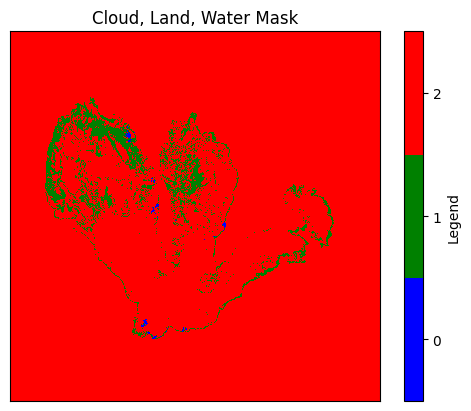

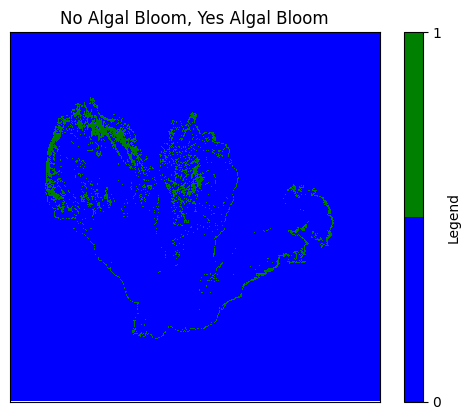

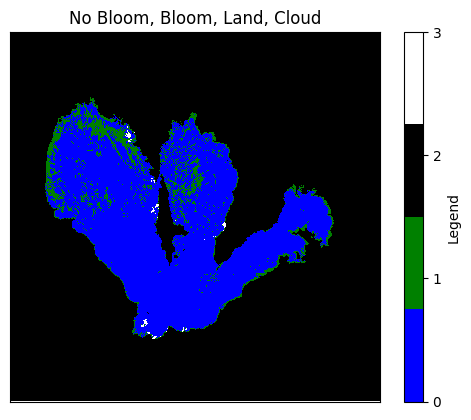

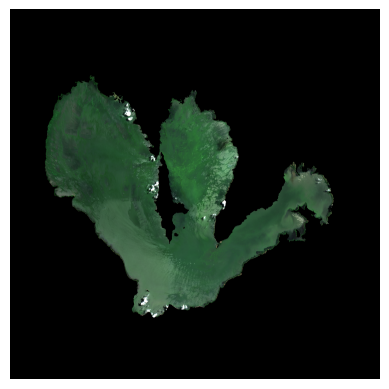

(183, 256, 256, 5)
(183, 256, 256, 1)


In [2]:
date_str= "2019-05-28" 

X = []
y = []

band2 = np.load(f'data/10m_msi_array/msi_array_band2_{date_str}.npy')
band3 = np.load(f'data/10m_msi_array/msi_array_band3_{date_str}.npy')
band4 = np.load(f'data/10m_msi_array/msi_array_band4_{date_str}.npy')
band8 = np.load(f'data/10m_msi_array/msi_array_band8_{date_str}.npy')
band11 = np.load(f'data/10m_msi_array/msi_array_band11_{date_str}.npy')

fai = np.load(f'data/10m_fai_mask/fai_mask_{date_str}.npy')


# Step 1: Load the image
image = Image.open("6000_resolution.png") # this mask is from 355 this is wrong

# Step 2: Convert to grayscale (if not already)
image = image.convert("L")  # 'L' mode is grayscale

# Step 3: Apply threshold to convert grayscale to binary (0 or 255)
# Assuming pixel intensity < 128 is black and >= 128 is white
threshold = 128
binary_image = np.array(image) > threshold

# Step 4: Convert boolean array to integer (1 for black, 0 for white)
binary_array = binary_image.astype(int)


band2[binary_array == 1] = 0
band3[binary_array == 1] = 0
band4[binary_array == 1] = 0
band8[binary_array == 1] = 0
band11[binary_array == 1] = 0
fai[binary_array == 1] = 0

from scipy.ndimage import binary_dilation

# Dilate array3 to include 5x5 neighborhood around each '1'
structure = np.ones((5, 5))  # A 5x5 square structure
array4 = binary_dilation(binary_array, structure=structure).astype(int)

array_normalized = np.uint8(array4* 255)  # Scale values to 0-255 if your array has 0 and 1 values

# Create a PIL Image from the array
img = Image.fromarray(array_normalized)

# Save the image as a PNG file
img.save('6000_laguna_5pixel_dilation.png')

# Stack the bands to create the input (shape: 255, 255, 5)
X.append(np.stack([band4, band3, band2, band8, band11], axis=-1))

# Convert the FAI mask to one-hot encoding (shape: 255, 255, 3)
fai_one_hot = to_categorical(fai, num_classes=2)
y.append(fai_one_hot)

X = np.array(X)
y = np.array(y)

count_1s_dim1 = np.sum(y[:, :, :, 0] == 1)
count_0s_dim1 = np.sum(y[:, :, :, 0] == 0)

count_1s_dim2 = np.sum(y[:, :, :, 1] == 1)
count_0s_dim2 = np.sum(y[:, :, :, 1] == 0)



print("Counts for last dimension index 1:")
print("1s:", count_1s_dim1, "0s:", count_0s_dim1)

print("Counts for last dimension index 2:")
print("1s:", count_1s_dim2, "0s:", count_0s_dim2)


# Step 1: Load the image
image = Image.open("6000_resolution.png") # this mask is from 355 this is wrong

# Step 2: Convert to grayscale (if not already)
image = image.convert("L")  # 'L' mode is grayscale

# Step 3: Apply threshold to convert grayscale to binary (0 or 255)
# Assuming pixel intensity < 128 is black and >= 128 is white
threshold = 128
binary_image = np.array(image) > threshold

# Step 4: Convert boolean array to integer (1 for black, 0 for white)
binary_array = binary_image.astype(int)

i = 0 # you can change this 

red = X[i:i+1, :, :, 0:1]
red =red [0, :, :, 0]

green = X[i:i+1, :, :, 1:2]
green =green[0, :, :, 0]

blue = X[i:i+1, :, :, 2:3]
blue  =blue [0, :, :, 0]

nir = X[i:i+1, :, :, 3:4]
nir =nir [0, :, :, 0]

swir = X[i:i+1, :, :, 4:5]
swir  =swir [0, :, :, 0]

band2 = blue
band3 = green
band4 = red 
band8 = nir
band11 = swir

fai = calculate_fai(band4, band8, band11)
combined_array = np.stack((band4,band3,band2,band8,band11 ), axis=-1)

cloud_mask, land_mask= create_masks_cloud_land(combined_array)
result_mask = create_mask(cloud_mask, land_mask)
display_mask_array(result_mask)

labels = classify_bloom(fai)
display_mask_array_bloom(labels)

labels_normalized = np.uint8(labels * 255)  # Scale values to 0-255 if your array has 0 and 1 values

# Create a PIL Image from the array
labels_img = Image.fromarray(labels_normalized)

# Save the image as a PNG file
labels_img .save('laguna_2019-05-28_algalbloom_mask.png')

final_image = create_mask_final(labels, binary_array,cloud_mask)

display_mask_array_final(final_image)

rgb_image = np.stack((red, green, blue), axis=-1)
rgb_image_holder = display_image_from_list(rgb_image, brightness_factor=3.5/10000, processed=True, display_image= True,save_img=False)


band2 = blue
band3 = green
band4 = red 
band8 = nir
band11 = swir

new_dim = 5888 # for final 256
new_patch = 256
#new_dim = 5865 # for now temporary 255

arr = band2  # Example 2000x2000 array
cropped_arr = crop_edges_to_center(arr, target_shape=(new_dim, new_dim))
patches_band2 = crop_array_to_patches(cropped_arr, patch_size=(new_patch, new_patch) )

arr = band3   # Example 2000x2000 array
cropped_arr = crop_edges_to_center(arr, target_shape=(new_dim, new_dim))
patches_band3 = crop_array_to_patches(cropped_arr , patch_size=(new_patch, new_patch))

arr = band4   # Example 2000x2000 array
cropped_arr = crop_edges_to_center(arr, target_shape=(new_dim, new_dim))
patches_band4 = crop_array_to_patches(cropped_arr, patch_size=(new_patch, new_patch) )

arr = band8   # Example 2000x2000 array
cropped_arr = crop_edges_to_center(arr, target_shape=(new_dim, new_dim))
patches_band8 = crop_array_to_patches(cropped_arr, patch_size=(new_patch, new_patch) )

arr = band11   # Example 2000x2000 array
cropped_arr = crop_edges_to_center(arr, target_shape=(new_dim, new_dim))
patches_band11 = crop_array_to_patches(cropped_arr , patch_size=(new_patch, new_patch))

X = []
for i in range(529):
    X.append(np.stack([patches_band4[i], patches_band3[i], patches_band2[i], patches_band8[i], patches_band11[i]], axis=-1))

X = np.array(X)


final_X =[]
final_y = []

for i in range(529):
    red = X[i:i+1, :, :, 0:1]
    red =red [0, :, :, 0]

    green = X[i:i+1, :, :, 1:2]
    green =green[0, :, :, 0]

    blue = X[i:i+1, :, :, 2:3]
    blue  =blue [0, :, :, 0]

    nir = X[i:i+1, :, :, 3:4]
    nir =nir [0, :, :, 0]

    swir = X[i:i+1, :, :, 4:5]
    swir  =swir [0, :, :, 0]

    band2 = blue
    band3 = green
    band4 = red 
    band8 = nir
    band11 = swir
    
    final_X.append(np.stack([band4, band3, band2, band8, band11], axis=-1))
    
    fai = calculate_fai(band4, band8, band11)
    labels = classify_bloom(fai)
    arr_expanded = np.expand_dims(labels, axis=-1)
    final_y.append(arr_expanded)
 
final_X = np.array(final_X)
final_y = np.array(final_y)

channels = [final_X[..., i] for i in range(5)]

red = reconstruct_array_from_patches(channels[0], original_shape=(5888, 5888), patch_size=(256, 256))
green = reconstruct_array_from_patches(channels[1], original_shape=(5888, 5888), patch_size=(256, 256))
blue = reconstruct_array_from_patches(channels[2], original_shape=(5888, 5888), patch_size=(256, 256))
nir = reconstruct_array_from_patches(channels[3], original_shape=(5888, 5888), patch_size=(256, 256))
swir = reconstruct_array_from_patches(channels[4], original_shape=(5888, 5888), patch_size=(256, 256))

band2 = blue
band3 = green
band4 = red 
band8 = nir
band11 = swir

# Step 1: Load the image
image = Image.open("5888_resolution.png") # this mask is from 355 this is wrong

# Step 2: Convert to grayscale (if not already)
image = image.convert("L")  # 'L' mode is grayscale

# Step 3: Apply threshold to convert grayscale to binary (0 or 255)
# Assuming pixel intensity < 128 is black and >= 128 is white
threshold = 128
binary_image = np.array(image) > threshold

# Step 4: Convert boolean array to integer (1 for black, 0 for white)
binary_array = binary_image.astype(int)

final_X = np.array(final_X)
final_y = np.array(final_y)

black_white = crop_array_to_patches(binary_array , patch_size=(new_patch, new_patch))
black_white = np.array(black_white)
non_uniform_indices = find_non_uniform_entries(black_white)
# Assuming `final_X` is your array of shape (529, 256, 256, 5) and `non_uniform_indices` is a list of indices
final_X_filtered = keep_non_uniform_entries(final_X, non_uniform_indices)
print(final_X_filtered.shape)  # It will have shape (len(remaining_indices), 256, 256, 5)


final_y_filtered = keep_non_uniform_entries(final_y, non_uniform_indices)
print(final_y_filtered.shape)  # It will have shape (len(remaining_indices), 256, 256, 5)


# model

In [3]:
# 2019-05-28 This data if form this date in laguna lake 

X, y = np.array(final_X_filtered ), np.array(final_y_filtered ) # the land is filtered

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):

    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
               kernel_initializer = 'he_normal', padding = 'same')(input_tensor)  
    if batchnorm:  
        x = BatchNormalization()(x)
    x = Activation('relu')(x)  
    
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
               kernel_initializer = 'he_normal', padding = 'same')(x)  
    if batchnorm:  
        x = BatchNormalization()(x)
    x = Activation('relu')(x)  
    
    return x 

def unet(input_img, n_filters = 8, dropout = 0.05, batchnorm = True, activation_function ="sigmoid"):
    """
    Build a U-Net model for image segmentation.
    
    Parameters:
        input_img (tensor): The input image tensor (height, width, channels).
        n_filters (int): The number of filters to use in all convolutional layers.
        dropout (float): Dropout rate to be applied after each pooling and upsampling layer.
        batchnorm (bool): Whether to use batch normalization after each convolutional layer.
        activation_function (str): The activation function for the final layer. Default is 'sigmoid' (for binary segmentation).
        
    Returns:
        model (tf.keras.Model): The U-Net model.
    """
    
    # Contracting Path (Encoder) - Down-sampling
    
    # First block
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)  
    p1 = MaxPooling2D((2, 2))(c1)  
    p1 = Dropout(dropout)(p1)  
    
    # Second block
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm) 
    p2 = MaxPooling2D((2, 2))(c2)  
    p2 = Dropout(dropout)(p2) 
    
    # Third block: Convolution without pooling (no down-sampling)
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)  
    
    # Expansive Path (Decoder) - Up-sampling
    
    # First up-sampling 
    u4 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c3)  
    u4 = concatenate([u4, c2])  
    u4 = Dropout(dropout)(u4) 
    c4 = conv2d_block(u4, n_filters * 2, kernel_size = 3, batchnorm = batchnorm) 
    
    # Second up-sampling 
    u5 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c4)  
    u5 = concatenate([u5, c1]) 
    u5 = Dropout(dropout)(u5)  
    c5 = conv2d_block(u5, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)  
    
    # Final output layer with 1 filter (for binary segmentation)
    outputs = Conv2D(1, (1, 1), activation=activation_function)(c5)  
    
    # Define the model with the input image tensor and the output
    model = Model(inputs=[input_img], outputs=[outputs])  
    
    return model  # Return the constructed U-Net model


In [5]:

# Set parameters
im_width = 256
im_height = 256
depth = 5  # Input has 5 channels
num_classes = 1  # Binary output, single channel

# Define input and model
input_img = Input((im_height, im_width, depth), name='img')

# Modify U-Net model for binary output
model = unet(input_img, n_filters=10, dropout=0.05, batchnorm=True, activation_function="sigmoid")  # Use sigmoid for binary

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.Precision(),
                       iou])  

# Define callbacks
callbacks = [
    #EarlyStopping(monitor='val_iou', patience=10, verbose=1, mode='max', min_delta=0.001),  # Stop if no significant improvement
    ReduceLROnPlateau(monitor='val_iou', mode='max', factor=0.5, patience=5, min_lr=1e-6, verbose=1),  # Reduce LR after 5 epochs of no improvement
    ModelCheckpoint('model_unet.weights.h5', monitor='val_iou', verbose=1, save_best_only=True, save_weights_only=True, mode='max'),
]


In [6]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)    │ (None, 256, 256,  │          0 │ -                 │
│                     │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        460 │ img[0][0]         │
│                     │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         40 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │        910 │ activation[0][0]  │
│                     │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         40 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      1,820 │ dropout[0][0]     │
│                     │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         80 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      3,620 │ activation_2[0][… │
│                     │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         80 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[

 Total params: 51,891 (202.70 KB)

 Trainable params: 51,491 (201.14 KB)

 Non-trainable params: 400 (1.56 KB)

In [7]:
results = model.fit(X_train, y_train, batch_size=8, epochs=50, callbacks=callbacks,
                    validation_data=(X_val, y_val))

Epoch 1/50


d:\3_apps\5_vscode_projects\final_project\algal_bloom_semantic_segmentation_models\.venv\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['img']. Received: the structure of inputs=*
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.7446 - iou: 0.2161 - loss: 0.6592 - precision: 0.2046
Epoch 1: val_iou improved from -inf to 0.18184, saving model to model_unet.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 438ms/step - accuracy: 0.7502 - iou: 0.2237 - loss: 0.6535 - precision: 0.2109 - val_accuracy: 0.5137 - val_iou: 0.1818 - val_loss: 0.6798 - val_precision: 0.1886 - learning_rate: 0.0010
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9516 - iou: 0.6185 - loss: 0.3873 - precision: 0.7299
Epoch 2: val_iou improved from 0.18184 to 0.21613, saving model to model_unet.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 413ms/step - accuracy: 0.9520 - iou: 0.6188 - loss: 0.3864 - precision: 0.7294 - val_accuracy: 0.6938 - val_iou: 0.2161 - val_loss: 0.5564 - val_precision: 0.2303 - learning_rate: 0.0010
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9625 - iou: 0.6645 - loss: 0.3119 - precision: 0.8147
Epoch 3: val_iou improved from 0.21613 to

In [8]:
epoch_sec = 16
epoch_count = 49

seconds = epoch_sec *epoch_count

seconds

784

In [21]:
def convert_to_seconds(minutes, seconds):
    total_seconds = (minutes * 60) + seconds
    return total_seconds

# Example usage:
minutes = 5
seconds = 13.4
total_seconds = convert_to_seconds(minutes, seconds)

print(f"Total seconds: {total_seconds}")

Total seconds: 313.4


In [10]:
history_df = pd.DataFrame(results.history)
history_df.to_csv('model_unet_history.csv', index=False)

In [11]:
# Path to your saved weights file
model_weights_path = 'model_unet.weights.h5'

# Load the weights into the model
model.load_weights(model_weights_path)

In [12]:
# Save the model
model.save('unet_model_full.keras')

# Get the size of the file in bytes
file_size = os.path.getsize('unet_model_full.keras')

# Convert the size to MB
file_size_mb = file_size / (1024 * 1024)

# Print the file size in MB
print(f'File Size: {file_size_mb:.2f} MB')


File Size: 0.77 MB


In [13]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('unet_model_full.keras', custom_objects={'iou': iou})

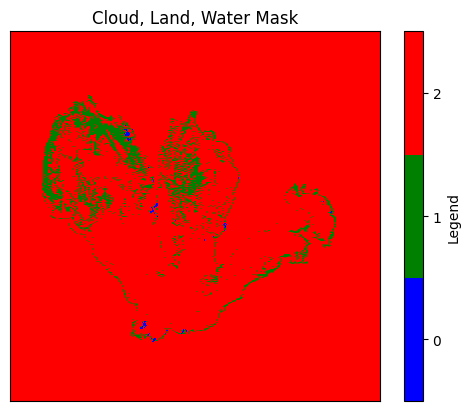

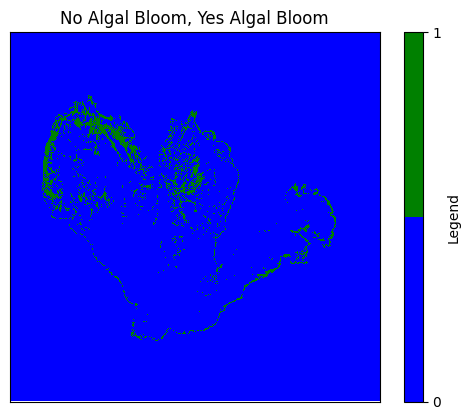

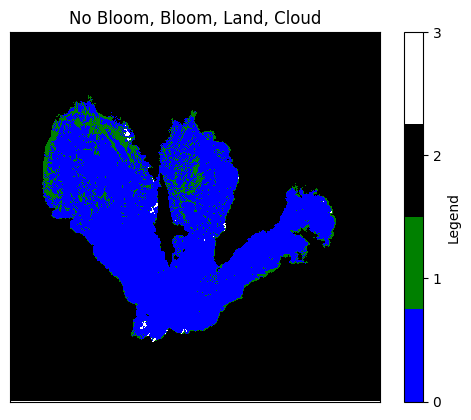

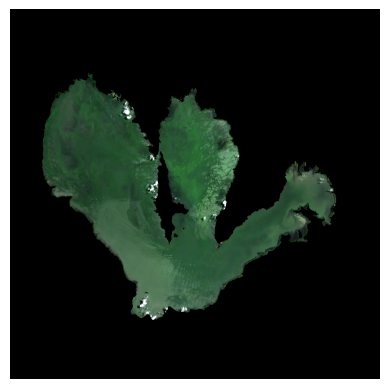

In [14]:
fai = calculate_fai(band4, band8, band11)
combined_array = np.stack((band4,band3,band2,band8,band11 ), axis=-1)

cloud_mask, land_mask= create_masks_cloud_land(combined_array)
result_mask = create_mask(cloud_mask, land_mask)
display_mask_array(result_mask)

labels = classify_bloom(fai)
display_mask_array_bloom(labels)

final_image = create_mask_final(labels, binary_array,cloud_mask)
display_mask_array_final(final_image)

rgb_image = np.stack((red, green, blue), axis=-1)
rgb_image = display_image_from_list(rgb_image, brightness_factor=3.5/10000, processed=True, display_image= True,save_img=False)

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step


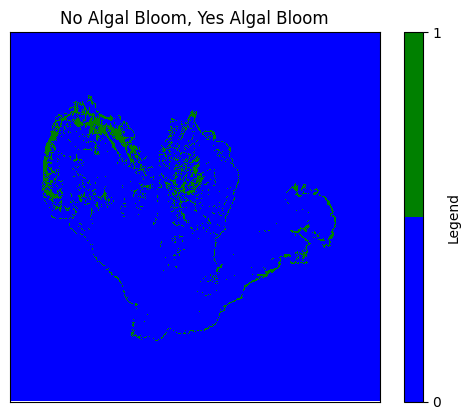

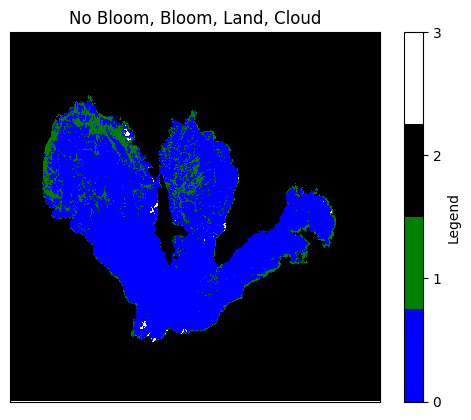

In [15]:
predictions = model.predict(final_X, batch_size=8)  # Batch predictions for efficiency

# Assuming the model outputs probabilities for class 1
predicted_classes = (predictions > 0.5).astype(int)
predictions_squeezed = np.squeeze(predicted_classes, axis=-1)

model_test_result = reconstruct_array_from_patches(predictions_squeezed, original_shape=(5888, 5888), patch_size=(256, 256))
display_mask_array_bloom(model_test_result)

final_image = create_mask_final(model_test_result, binary_array,cloud_mask)
display_mask_array_final(final_image)

In [16]:
model.evaluate(final_X_filtered , final_y_filtered)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - accuracy: 0.9867 - iou: 0.8982 - loss: 0.0464 - precision: 0.9669


[0.03850679099559784,
 0.9897118210792542,
 0.9672312140464783,
 0.8902191519737244]

# History

In [17]:
import pandas as pd
# Load the CSV file to inspect its contents
file_path = "model_unet_history.csv"
data = pd.read_csv(file_path)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   accuracy       50 non-null     float64
 1   iou            50 non-null     float64
 2   loss           50 non-null     float64
 3   precision      50 non-null     float64
 4   val_accuracy   50 non-null     float64
 5   val_iou        50 non-null     float64
 6   val_loss       50 non-null     float64
 7   val_precision  50 non-null     float64
 8   learning_rate  50 non-null     float64
dtypes: float64(9)
memory usage: 3.6 KB


In [19]:
def plot_model_history(data, model_name):
    """
    Plots the training and validation metrics from a given DataFrame and includes the model architecture name.
    
    Parameters:
    data (pd.DataFrame): The data containing training and validation metrics.
    model_name (str): Name of the model architecture to display on the plot.
    """
    import matplotlib.pyplot as plt

    metrics = ['accuracy', 'iou', 'loss', 'precision']
    val_metrics = ['val_' + metric for metric in metrics]

    # Create subplots for each metric
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        ax = axes[i]
        ax.plot(data[metric], label=f'Train {metric}', color='blue')
        ax.plot(data[val_metrics[i]], label=f'Validation {metric}', color='orange')
        ax.set_title(f'{metric.capitalize()} Over Epochs')
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric.capitalize())
        ax.legend()
        ax.grid()

    # Add a title for the entire figure with the model name
    fig.suptitle(f'Model Performance: {model_name}', fontsize=16, weight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the suptitle
    plt.show()


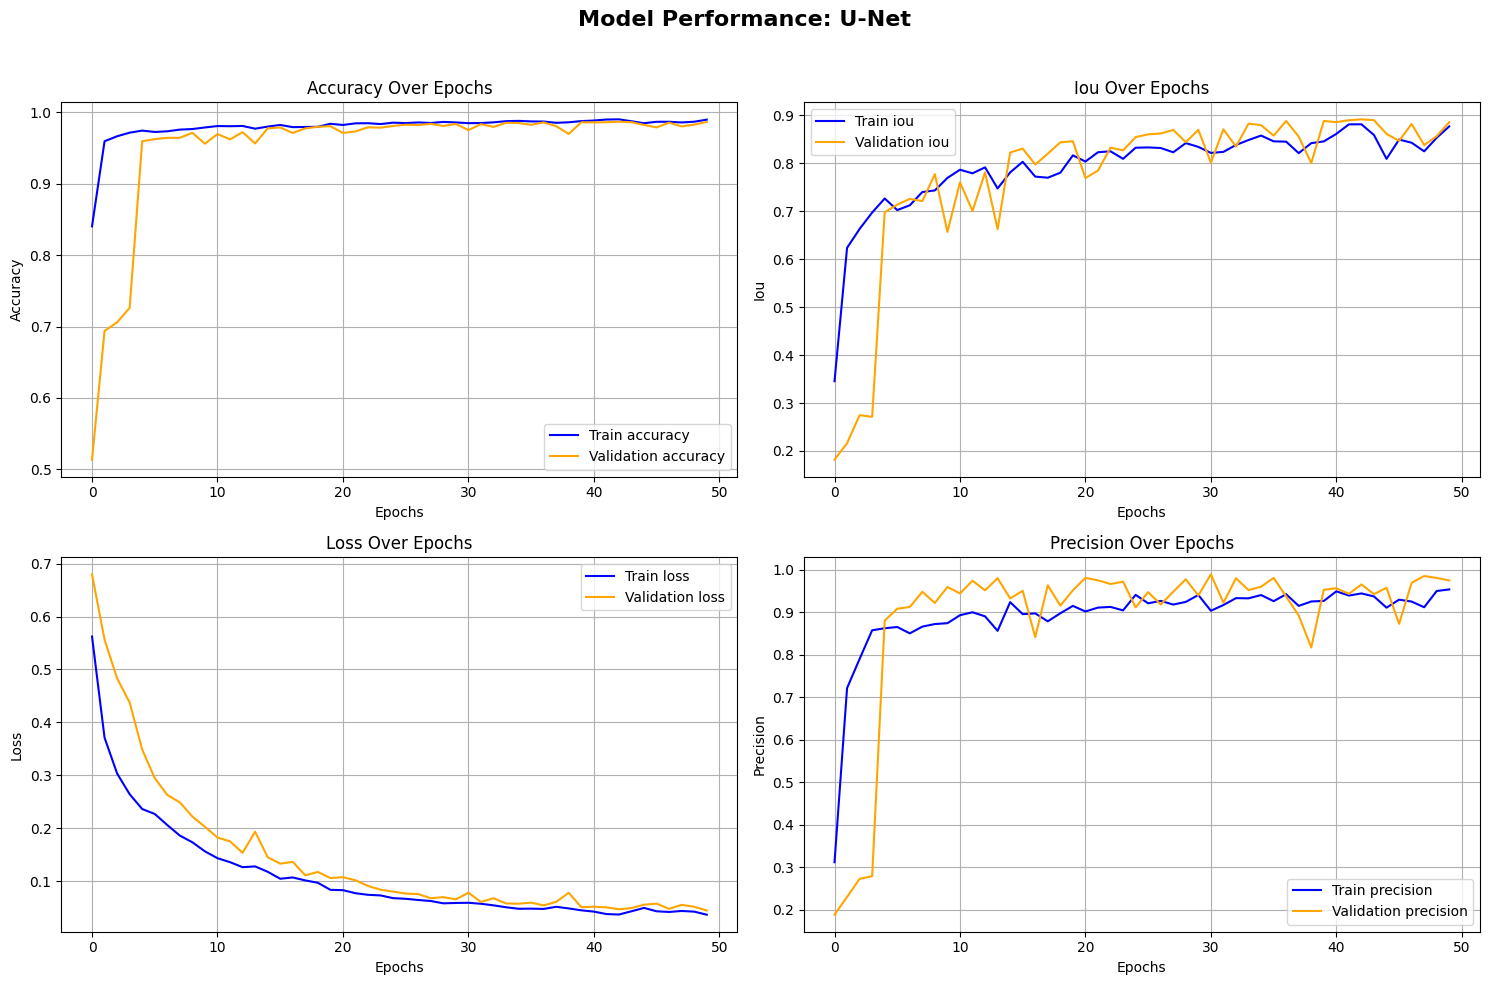

In [20]:
plot_model_history(data, "U-Net")